<a href="https://colab.research.google.com/github/mthakur08/Deep_Learning_Skim_Lit/blob/main/DeepLearningBook1_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2 - Skimlit


*   The purpose of this project is to make reading medical abstracts 
easier (the source of the dataset is available : https://arxiv.org/abs/1710.06071).
*   And reading through the paper above, we see that the model architecture that they were using to get the best results is available here: https://arxiv.org/abs/1612.05251
*   📚 **Resource** If you want to see the ground truth for this note book (with lots of diagrams and annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning.
                         

## Confirm access to a GPU


In [245]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get Data

> Since we'll be replicating the paper above (PubMed 200K RCT), let's download the dataset they used

> We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [246]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [247]:
# Check what files are in the PubMed-20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [248]:
#Start our experiments using the 20K dataset with numbers replaced by the at sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [249]:
#Check all of the filenames inthe target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [250]:
# Create a function to read the lines of a document

def get_lines(filename):
  """
  Reads a filename (a text filename) and returns the lines of a text as a list.

  Args:
    filename: a string containing he target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """    
  with open(filename, "r") as f:
      return f.readlines() #read how to read text files in python


In [251]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") #read the lines within the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

##Let's plan our pre-processing

In [252]:
#Check the length of the data
len(train_lines)

210040



*   Let's think about how we want our data to look...
*   How I think out data would be best represented...

⭐ We want to retrun a _**list of dictionaries**_ which is compatible with _**pandas**_:

```
[{'line number': 0,
  'target': "BACKGROUND"
  'text': "Emotional eating is associated with overeating and the development of obesity .\n",
  'total_lines': 11}]
```



###Lets write a function which turn each of our data into the above format so we can continue to progress

In [253]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) #get all the lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  #Loop through each lines in the target file
  for line in input_lines:
    if line.startswith("###"): #check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the line is an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines

      #iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") #split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower case
        line_data["line_number"] = abstract_line_number #what number does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 #how many total lines are there (we want to start from 0 - thats why we subtract 1)
        abstract_samples.append(line_data)#add line data dictionnary to abstract_samples list so we can return it
    else: #if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples




## Preprocess our Data

In [254]:
#Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")#dev is another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 752 ms, sys: 140 ms, total: 892 ms
Wall time: 908 ms


In [255]:
# chech the first few abstracts of our trainingdata
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

### Visualize the data as a Pandas DataFrame



In [256]:
#Turn our dictionary into pandas dataframe to visualize it
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [257]:
#Check districution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

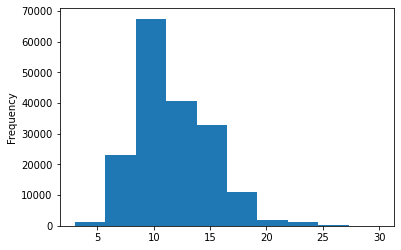

In [258]:
# Let's look at the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [259]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [260]:
# Check out 1st 10 samples of train_sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Turning out target labels into numbers

###One Hot Encode

In [261]:
# One hot encode labels
# sklearn has one hot encoder
import sklearn
from sklearn.preprocessing import OneHotEncoder
#one_hot_encode
one_hot_encoder = OneHotEncoder(sparse=False)
#sparce = False forces it as a dense(not sparse) matrix which uses more memory (tensorflow doesn't run on sparse matrices)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
#you have to reshape to (-1,1) otherwise shape error 
#fit_transform does the one hot encoding; once you've fit_transform on train_labels, you can just transform the val_labels and test_labels
#its not necessary to fit anymore, thats already done
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [262]:
#Lets see how it looks
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

###Label Encode labels

In [263]:
#Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [264]:
#Let's see how this look likes
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

### Get class names and map it back from LabelEncoder instance

In [265]:
num_classes = len(label_encoder.classes_)
#dont forget the underscore after classes
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Model 0 (Baseline)
*   Naive Bayes TF-IDF Explorer (used in text)
*   A good/basic explanation of Bayes Theorem: https://www.youtube.com/watch?v=Q8l0Vip5YUw
*   Formula for Naive Bayes theorem (conditional probability for A, given that B has occurred):

\begin{align}
        P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)}
    \end{align}

*   Go to Scikit learn Machine learning map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html to help decide which baseline model to choose
*   The following article explains tfidf: http://tfidf.com
TF-IDF is a way to assesss the importance of a word look at frequency of occurence increased frequency 
means increased importance, but it is off set by the frequency accross more documents so that
words like as, and, in, of, etc.  have diminished importance in the final  analysis
*   The formula for TF-IDF:
    1.   TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
    2.   IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
    3.   TF(t) * IDF(t)
*   Check out Chris Albon website: https://chrisalbon.com

In [266]:
# TfidfVectorizer: Converts a collection of raw documents to a matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
# MultinomialNB is a Naive Bayes classifier for multinomial models.
from sklearn.naive_bayes import MultinomialNB
# The model is created within a pipeline from sklearn
from sklearn.pipeline import Pipeline

###Create a SKLearn Pipeline and Fit the Data



In [267]:
# create the Pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])
# fit the pipeline to the training data
#Multinomial currently does not accept one hot encoded, only encoded
model_0.fit(X=train_sentences,
            y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

###Score(Evaluate) our model

In [268]:
# SKLearn uses score not evaluate as in Keras; returns accuracy as the metric
print(f"The accuracy of our model bassed on validation data is {round(model_0.score(X=val_sentences, y=val_labels_encoded),3)}.")

The accuracy of our model bassed on validation data is 0.722.


### Make predicitons using our baseline model

In [269]:
# returns an array of numerical labels 
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [270]:
# check val_labels_encoded
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### 🧤 Helper Function: calculate_results()

*   Calculates model accuracy, precision, recall, and f1 score of a binary classsification model.

In [271]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall, and f1 score of a binary classsification model.

    Args:
        y_true: true labels in the form of a 1d array.
        y_pred: predicted labels in the form of a 1d array.

    Returns a dictionary of accuracy, precision, recall, and f1-score.
    """
    # Calculate model_accuracy
    model_accuracy = accuracy_score(y_true,y_pred)*100
    # Calculate model_precision, recall, and f1-score using weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy":model_accuracy,
                     "precision": model_precision,
                     "model_recall": model_recall,
                     "model_f1": model_f1}
    return model_results


### Calculate baseline results

In [272]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=baseline_preds)
for k, v in baseline_results.items():
    print(k, '=', round(v,3))

accuracy = 72.183
precision = 0.719
model_recall = 0.722
model_f1 = 0.699


## Model 1 - Conv1d

### Preparing our data (the text) for deep sequence models

#### Create Vectorization and Embedding Layers - Preparation

In [273]:
#import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [274]:
#how long is each sentence on average
# the following takes a list of sentences(train_sentences) and splits it to token level
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = round(np.mean(sent_lens),2)
print(f" Our average sentence length is {avg_sent_len} words.")
                 

 Our average sentence length is 26.34 words.


The average tells you how long and whether you need to pad or truncate

(array([1.1050e+03, 3.5170e+03, 7.7850e+03, 1.3079e+04, 1.6589e+04,
        1.8463e+04, 1.8770e+04, 1.7656e+04, 1.5580e+04, 1.3302e+04,
        1.1002e+04, 9.0040e+03, 7.0390e+03, 5.5540e+03, 4.2780e+03,
        3.3890e+03, 2.7020e+03, 2.1960e+03, 1.7050e+03, 9.5300e+02,
        1.1780e+03, 9.0000e+02, 7.5000e+02, 6.0900e+02, 4.9400e+02,
        4.0100e+02, 3.5000e+02, 2.5000e+02, 2.2900e+02, 2.1500e+02,
        1.6700e+02, 1.2600e+02, 1.0200e+02, 1.0100e+02, 6.4000e+01,
        6.1000e+01, 5.5000e+01, 4.5000e+01, 4.0000e+01, 2.5000e+01,
        2.5000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.6000e+01,
        1.0000e+01, 7.0000e+00, 1.6000e+01, 7.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 1.00

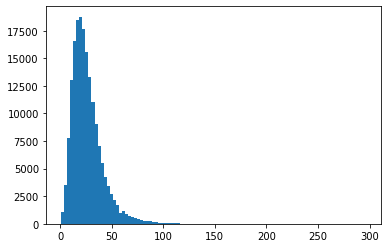

In [275]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=100)

In [276]:
#use numpy.percentile - how long of a sentence length covers 95% of example - 
#use this to decide where to truncate/pad
output_seq_length = int(np.percentile(sent_lens, 95))
print(f"The length of sentence which covers 95% of our samples: {output_seq_length}.")

The length of sentence which covers 95% of our samples: 55.


Use 55 as length for sentences

In [277]:
# check max, min, mean, median length
print(f" Maximum sentence length = {max(sent_lens)}\n",
      f"Minimum sentence length = {min(sent_lens)}\n", 
      f"Average sentence length = {round(np.mean(sent_lens), 2)}\n",
      f"Median sentence length = {np.median(sent_lens)}")

 Maximum sentence length = 296
 Minimum sentence length = 1
 Average sentence length = 26.34
 Median sentence length = 23.0


296 words in max sentence length.
Can't use 296 as that is too long for our analysis - most data will be padded and that won't be an efficient use of computing power.  55 will cover 95% of sentences

#### Create text vectorizer layer
The documentation for the keras text vectorizer:
https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/

In [278]:
#create the text vectorizer
#max_tokens is the most common vocab out of your set (everything else is OOV - out of vocabulary)
#the paper tells us that the max voc size is 60,000 
#taken from table 2 in http://arvix.org/pdf/1710.06071.pdf
max_tokens = 68000

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_seq_length,
                                    pad_to_max_tokens=True
                                    )
# max_tokens = number of words in vocabulary (obtained from paper)
# output_sequence_length is the sentence length that we determined earlier(55)
# which will cover 95% of sentences
# leave other parameterss as default

#### Adapt text vectorizer to training data

In [279]:
#adapt only train data and later fit val and test data
text_vectorizer.adapt(train_sentences)

#### Let's test out text Vectorizer


In [280]:
#lets test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}") # Need to get .split() as it maps words, otherwise it will give length of characters
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")


Text:
although non-experimental , this study will generate first large-scale data on the utility of imaging-enhancing algorithms in whole-body mdct for major blunt trauma .

Length of text: 24

Vectorized text: [[  311 25517    23    17    95  5440   152  4027   100    18     2  2049
      4 55347  4608     5  4734  6635    11   347  6313  1564     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


The above output, the vectorized array, maps words to their frequency (e.g. "and" is 3).  It drops punctuations and numbers.  The rest is padded with 0s up to 55.

In [281]:
#How many words in our training Vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary : {len(rct_20k_text_vocab)}")
print(f"Most common words : {rct_20k_text_vocab[:5]}") #vectorizer automatically sorts by frequency
print(f"Least common words : {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary : 64841
Most common words : ['', '[UNK]', 'the', 'and', 'of']
Least common words : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [282]:
#Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_3',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

#### Create custom text embedding

In [283]:
# Create token embedding layer
# input-dim is the length of the vocab
# output_dim - this is user set, multiple of 8 preferred
# mask_zero - this masks zero padding to save space (when there are lots of zeros)
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True
                               )

####Show embedding as an example with a random sentence


In [284]:
print(f"Sentence before vectorization:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape:\n {embedded_sentence.shape}")


Sentence before vectorization:
although non-experimental , this study will generate first large-scale data on the utility of imaging-enhancing algorithms in whole-body mdct for major blunt trauma .
Sentence after vectorization (before embedding):
 [[  311 25517    23    17    95  5440   152  4027   100    18     2  2049
      4 55347  4608     5  4734  6635    11   347  6313  1564     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.00693591 -0.00742729 -0.04459256 ... -0.03230357  0.03983481
    0.0173936 ]
  [-0.01231196 -0.04992813 -0.04221689 ...  0.03938358 -0.00787685
    0.03249088]
  [-0.03342295  0.00976484  0.0322472  ...  0.01249125 -0.04069443
   -0.02671367]
  ...
  [ 0.0454901  -0.0359956  -0.04036741 ... -0.03350518 -0.02188538
    0.02923382]
  [ 0.0454901  -0.0359956  -0.04036741 ... -0

####Create a fast loading dataset
Making sure the data loads as fast as possible.  Two guides:
*   https://www.tensorflow.org/guide/data_performance
*   https://www.tensorflow.org/guide/data



##### Turn our data into Tensorflow dataset

In [285]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [286]:
#as a review, lets look at our train_labels_one_hot
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

##### Take our datasets and turn them into prefetched datasets for improved performance

✅ Need to read tf performance modules

In [287]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Building a Conv1d model with token embeddings